# Часть 2. Сегментация

В этом ноутбуке попробуем сегментировать различные аномалии на картинках. Для начала попробуем сегментировать фотографии со вскрытием грунта, которые были размечены вручную

### Сегментация вскрытия грунта

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from skimage.io import imread
import os
root = '/content/drive/MyDrive/Nemezida UAV/Аномалии/Вскрытие грунта/Разметка/holes'

In [25]:
from skimage.transform import resize
size = (256, 256)

In [4]:
import numpy as np

In [5]:
from torchvision import transforms

In [6]:
import albumentations as albu
from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset, random_split

In [26]:
from albumentations import (
    CLAHE, RandomRotate90, Transpose, RandomCrop, VerticalFlip, Resize, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, HorizontalFlip, OneOf, Compose, PadIfNeeded, LongestMaxSize, PadIfNeeded, ElasticTransform,Cutout
)

In [68]:
train_trans = Compose([
        RandomCrop(*size),
        HorizontalFlip(),
        VerticalFlip(),
        ToTensor()
    ])

In [93]:
val_trans = Compose([
        RandomCrop(*size),
        ToTensor()
])

В папке с путём path находится две папки: "X" - фотографии и "y" - их маски

In [70]:
from pathlib import Path
path = Path(root)
files = os.listdir(path / 'X')

In [11]:
from sklearn.model_selection import train_test_split

In [96]:
train, val = train_test_split(files, test_size=0.18, random_state=0)

In [97]:
class Myds(Dataset):
    def __init__(self, path, filenames, phase):
        self.path = path

        self.img_names = sorted(filenames)

        if phase == 'train': 
            self.transform = train_trans
        elif phase == 'val': 
            self.transform = val_trans
        
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.path, 'X', self.img_names[idx])
        mask_path = os.path.join(self.path, 'y', self.img_names[idx])

        img = imread(img_path)
        mask = imread(mask_path, as_gray=True)

        
        data = {'image': img.astype('uint8'), 'mask': mask}
        augmented = self.transform(**data)

        return augmented['image'], augmented['mask']
    
    def __len__(self):
        return len(self.img_names)


In [98]:
train_ds = Myds(root, train, phase='train')
val_ds = Myds(root, val, phase='val')

In [99]:
from torch.utils.data import DataLoader

data_tr = DataLoader(train_ds, batch_size=14, shuffle=True)
data_val = DataLoader(val_ds, batch_size=4, shuffle=False)

In [100]:
from torchvision.transforms import functional as F

Вручную были созданы маски с аномалиями (белым цветом выделены аномалии). Посмотрим на фотографии вместе с их масками

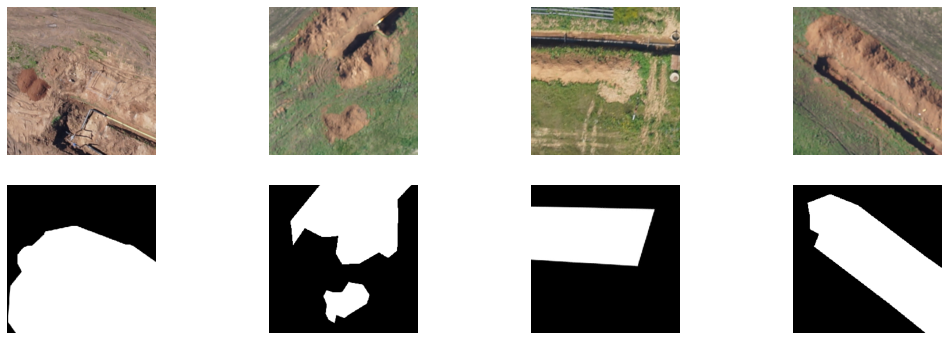

In [76]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

K = 4
X_train, y_train = next(iter(data_tr))
plt.figure(figsize=(18, 6))
for i in range(K):
    plt.subplot(2, K, i+1)
    plt.axis("off")
    plt.imshow(F.to_pil_image(X_train[i]))

    plt.subplot(2, K, i+1+K)
    plt.axis("off")
    plt.imshow(F.to_pil_image(y_train[i]), cmap='gray')
plt.show();

In [77]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Объявим класс модели UNet

In [101]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(3, 2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(3, 2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(3, 2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=2, dilation=2),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(1024, 512, 3, padding=2, dilation=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)# 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)   # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x) # 64x256x256
        e1 = self.enc_conv1(self.pool0(e0)) # 128x128x128
        e2 = self.enc_conv2(self.pool1(e1)) # 256x64x64
        e3 = self.enc_conv3(self.pool2(e2)) # 512x32x32

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3)) # 512x16x16

        # decoder
        d0 = self.dec_conv0( torch.cat((e3, self.upsample0(b)), dim=1) ) # (512+512)x32x32
        d1 = self.dec_conv1( torch.cat((e2, self.upsample1(d0)), dim=1) ) # (256+256)x64x64
        d2 = self.dec_conv2( torch.cat((e1, self.upsample2(d1)), dim=1) ) # (128+128)x64x64
        d3 = self.dec_conv3( torch.cat((e0, self.upsample3(d2)), dim=1) ) # (64+64)x64x64  # no activation
        return d3

Метрика, по которой будет оцениваться качество - IOU. По сути, это область пересечения предсказанной маски и реальной, деленная на общую область, занимаемую этими масками

In [80]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte() 
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  
    union = (outputs | labels).float().sum((1, 2))        
    
    iou = (intersection + SMOOTH) / (union + SMOOTH) 
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    
    return thresholded

Объявляем функцию лосса

In [81]:
def bce_loss(y_real, y_pred):
    return ( y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)) ).mean()

In [105]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train() 
        for X_batch, Y_batch in data_tr:

            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)


            opt.zero_grad()

            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()

            avg_loss += loss.item() / len(data_tr)
        toc = time()

        model.eval() 
        with torch.no_grad():
            Y_hat = model(X_val.to(device)).cpu()


        clear_output(wait=True)
        for k in range(K):
            plt.subplot(2, K, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Реальное изображение')
            plt.axis('off')

            plt.subplot(2, K, k+1+K)
            plt.imshow(Y_hat[k, 0] > 0, cmap='gray')
            plt.title('Выходы модели')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, bce_loss(Y_val, Y_hat)))
        plt.show()

In [83]:
def predict(model, data):
    model.eval() 
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [114]:
def score_model(model, metric, data):
    model.eval() 
    scores = 0
    for X_batch, Y_label in data:
        Y_label = Y_label > 0.5
        Y_pred = model(X_batch.to(device)) > 0
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [102]:
model = UNet().to(device)

In [111]:
max_epochs = 10
loss_fn = bce_loss
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

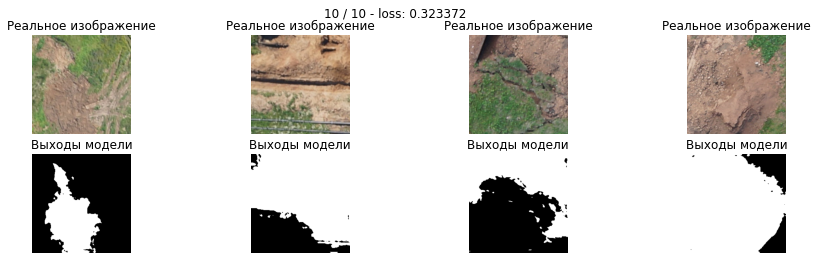

In [112]:
train(model, optim, loss_fn, max_epochs, data_tr, data_val)

Оценим качество обученной модели

In [115]:
score_model(model, iou_pytorch, data_val)

0.6499999761581421

Итак, IOU оказался равным 65%, что довольно неплохой результат для задачи сегментации. Попробуем посмотреть предсказания для картинки из тестовой выборки

In [ ]:
a = plt.imread('Вскрытие грунта (5).JPG')

In [ ]:
a = a[300:900, 3500:4200, :]

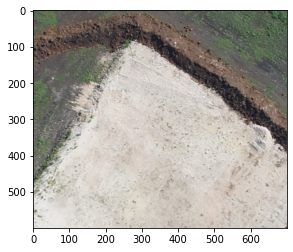

In [ ]:
plt.imshow(a[300:900, 3500:4200, :])

In [ ]:
a = torch.tensor(np.rollaxis(a, 2, 0)[None, :]/255, dtype=torch.float32)

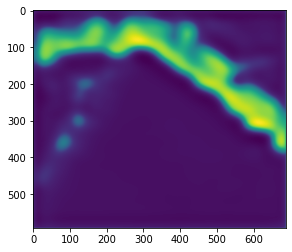

In [ ]:
plt.imshow(model(a.cuda())[0, 0].detach().cpu().numpy())

Видим, что данная аномалия хорошо сегментируется

Таким образом, мы смогли сегментировать вскрытие грунта на фотографиях. Как насчёт разливов нефти?

### Сегментация разливов нефти

Для сегментации разливов нефти также была произвдена ручная разметка фотографий. Посмотрим на фотографии и получившиеся маски

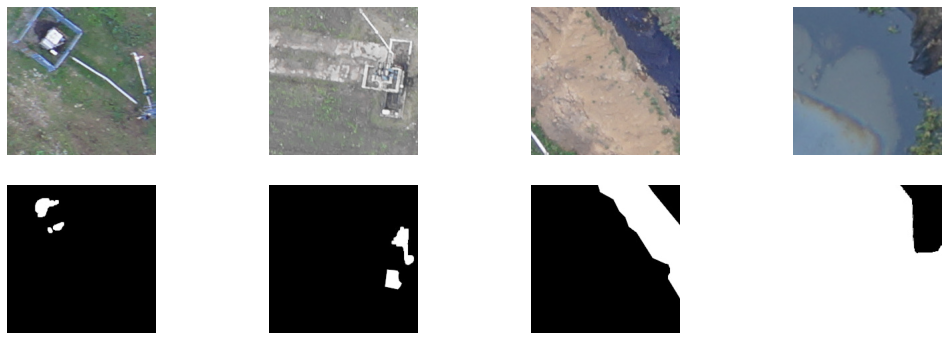

In [3]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

X_train, y_train = next(iter(data_tr))
plt.figure(figsize=(18, 6))
for i in range(K):
    plt.subplot(2, K, i+1)
    plt.axis("off")
    plt.imshow(F.to_pil_image(X_train[i]))

    plt.subplot(2, K, i+1+K)
    plt.axis("off")
    plt.imshow(F.to_pil_image(y_train[i]), cmap='gray')
plt.show();

После обучения модель выдавала такие результаты:

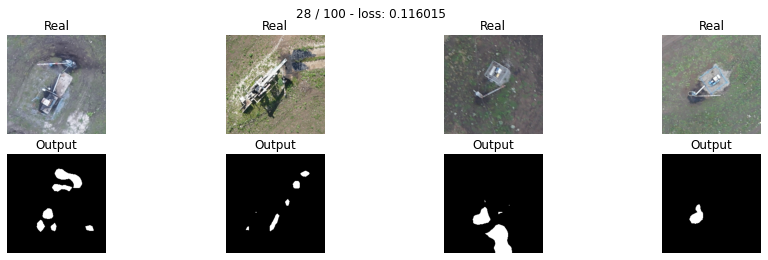

In [1]:
train(model, optim, loss_fn, max_epochs, data_tr, data_val)

Значение IOU получилось небольшое. Всё потому, что области с разливами нефти слишком маленькие, а также очень мало данных, содержащих эту аномалию. Попробуем воспользоваться другим интересным методом

### Автоэнкодеры для обнаружения разливов нефти

Данный подход основан на том, что мы обучаем нашу модель (автоэнкодер) на нормальных данных (скважинах без разливов), а после обучения подаём на вход фотографии с аномалиями и смотрим на результат. Если результаты метрики (например, MSE) сильно отклоняются от нормального значения, то на данной фотографии аномалия. Для начала разрежем все фотографии без аномалий и обучим на этом автоэнкодер.

In [ ]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

Будем сжимать разрезанные фотографии к 512х512

In [ ]:
import torchvision
from torchvision import transforms, models

trans = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

Создадим папки, в которые будем сохранять разрезанные фотографии

In [ ]:
import os
os.makedirs('data/no_razliv', exist_ok=True) # скважины
os.makedirs('data/relief', exist_ok=True) # рельеф
os.makedirs('data/objs', exist_ok=True) # различные объекты

Функция для разрезания фотографии на фотографии размера width x height

In [ ]:
def crop_save(img_paths, out_path, height=2000, width=2000, dim=(512,512)):
    for img_path in tqdm(img_paths):
        img = Image.open(img_path)
        for y in range(0, img.size[1], height):
            for x in range(0, img.size[0], width):
                box = (x, y, x+width, y+height)
                spam = img.crop(box)
                spam = spam.resize(dim)
                spam.save(out_path+'/'+img_path.stem+f'_{y//height}_{x//width}'+img_path.suffix)

In [ ]:
from pathlib import Path
no_razliv = list(Path('/content/drive/MyDrive/Nemezida UAV/Фото без отклонений/Скважины без разливов').glob('*.JPG'))
relief = list(Path('/content/drive/MyDrive/Nemezida UAV/Фото без отклонений/Рельеф').glob('*.JPG'))
objs = list(Path('/content/drive/MyDrive/Nemezida UAV/Фото без отклонений/Объекты без отклонений').glob('*.JPG'))

In [ ]:
from tqdm.notebook import tqdm
from PIL import Image

In [ ]:
if True:
    crop_save(no_razliv, 'data/no_razliv')
    crop_save(relief, 'data/relief')
    crop_save(objs, 'data/objs')

Класс датасета

In [ ]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision import transforms
from torchvision.transforms import functional as F
plt.style.use('ggplot')


class dataset(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.files = os.listdir(root)
    def __getitem__(self, idx):
        img = Image.open(self.root / self.files[idx])
        return trans(img)
    def __len__(self):
        return len(self.files)

In [ ]:
ds = dataset('No_razliv')

Делим данные на тренировочную и валидационную выборки

In [ ]:
train_size = int(0.8*len(ds))
train_ds, val_ds = random_split(ds, [train_size, len(ds)-train_size])

In [ ]:
train_dl = DataLoader(train_ds, shuffle=True, batch_size=4)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=4)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [ ]:
import matplotlib.pyplot as plt

Объявляем класс модели автоэнкодера

In [ ]:
from torch import nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=3, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            
            nn.Conv2d(6, 6, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(6),
            nn.ReLU()
        )
        
        self.encoder2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16, 16, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        
        self.encoder3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
            
        self.decoder1 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        
        self.decoder2 = nn.Sequential( 
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 6, kernel_size=3, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            
            nn.Conv2d(6, 6, kernel_size=3, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU()
        )
        
        self.decoder3 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(6, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            
            nn.Conv2d(3, 3, kernel_size=3, padding=1),
        )
    def forward(self,x):
        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)

        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)
        return x

In [ ]:
model = Autoencoder().to('cuda')

In [ ]:
def train(model, loss_fn, opt, num_epoch, train_dl, val_dl):
    for epoch in range(num_epoch):
        print('* Epoch', epoch+1)
        epoch_loss = 0.
        for X_tr in train_dl:
            X_tr = X_tr.to(device)
            X_pred = model(X_tr)
            loss = loss_fn(X_pred, X_tr)
            epoch_loss += loss.item()
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        tr_spam = epoch_loss / len(train_dl)
        print('Train loss:', tr_spam)
        tr_loss.append(tr_spam)
            
        with torch.no_grad():
            X_val = next(iter(val_dl))
            X_val = X_val.to(device)
            X_hat = model(X_val)
            
            val_spam = loss_fn(X_hat, X_val).item()
            print('Val loss:', val_spam)
            val_loss.append(val_spam)

In [ ]:
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
tr_loss, val_loss = [], []
train(model, loss_fn, opt, 100, train_dl, val_dl)

* Epoch 1
Train loss: 0.32052573561668396
Val loss: 0.3778456449508667
* Epoch 2
Train loss: 0.26773325353860855
Val loss: 0.3334784507751465
* Epoch 3
Train loss: 0.23317458853125572
Val loss: 0.29246270656585693
* Epoch 4
Train loss: 0.20085591822862625
Val loss: 0.24681584537029266
* Epoch 5
Train loss: 0.16679711267352104
Val loss: 0.2083752155303955
* Epoch 6
Train loss: 0.13092456199228764
Val loss: 0.17032615840435028
* Epoch 7
Train loss: 0.09284000284969807
Val loss: 0.13019311428070068
* Epoch 8
Train loss: 0.07118015084415674
Val loss: 0.10670235008001328
* Epoch 9
Train loss: 0.05547388456761837
Val loss: 0.09583662450313568
* Epoch 10
Train loss: 0.05327335838228464
Val loss: 0.08122803270816803
* Epoch 11
Train loss: 0.048700615763664246
Val loss: 0.0739145576953888
* Epoch 12
Train loss: 0.03738970123231411
Val loss: 0.0763934850692749
* Epoch 13
Train loss: 0.04149026423692703
Val loss: 0.06672858446836472
* Epoch 14
Train loss: 0.03991705644875765
Val loss: 0.059675853

KeyboardInterrupt: 

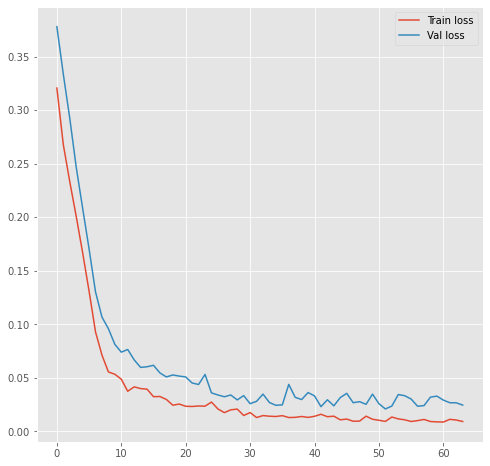

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(tr_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend();

Посмотрим на результаты обучения модели: пропустим фотографии с аномалиями

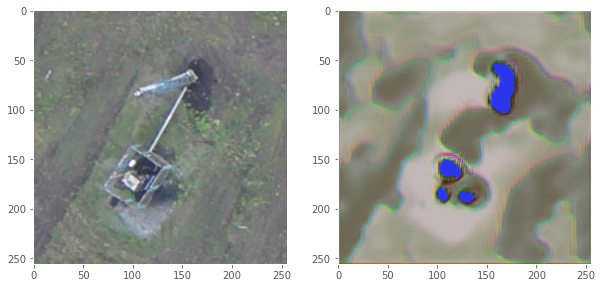

In [ ]:
x = trans(Image.open(r"razliv10_2.JPG"))
pil = F.to_pil_image
pred = model(x[None, :].cuda()).squeeze().cpu()

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(pil(x))
plt.grid()

plt.subplot(1, 2, 2)
plt.imshow(pil(pred), cmap='gray')
plt.grid()

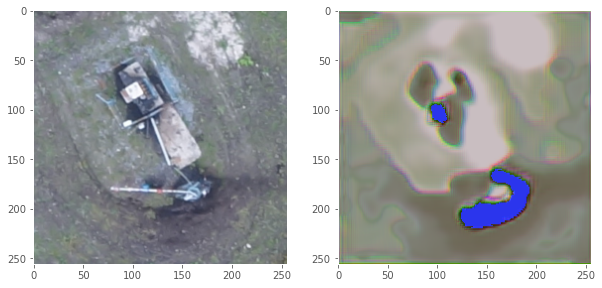

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(pil(x))
plt.grid()

plt.subplot(1, 2, 2)
plt.imshow(pil(pred), cmap='gray')
plt.grid()

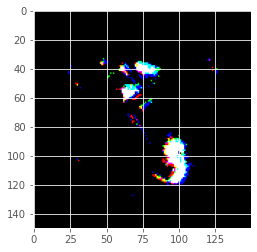

In [ ]:
# для последней картинки вычтем предсказания 
# из картинки и возьмём значения, 
# которые выходят за интерквартильный размах справа
a = (x - pred).detach().numpy()
q1 = np.quantile(a, 0.25)
q3 = np.quantile(a, 0.75)
plt.imshow( (a > q3 + 1.5 * (q3-q1)).transpose(1, 2, 0).astype(int)*255 )

Результаты обучения для другого запуска модели

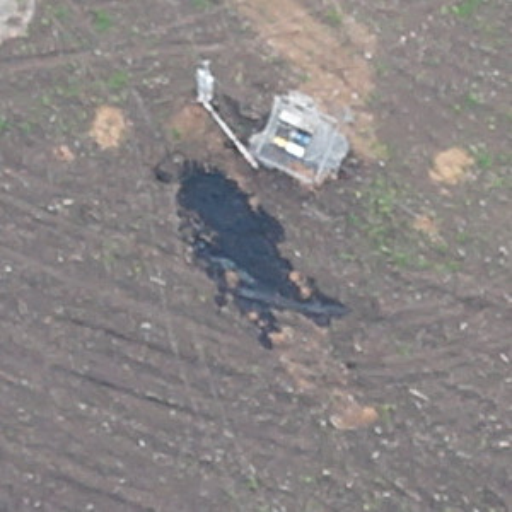

In [152]:
pil(x)

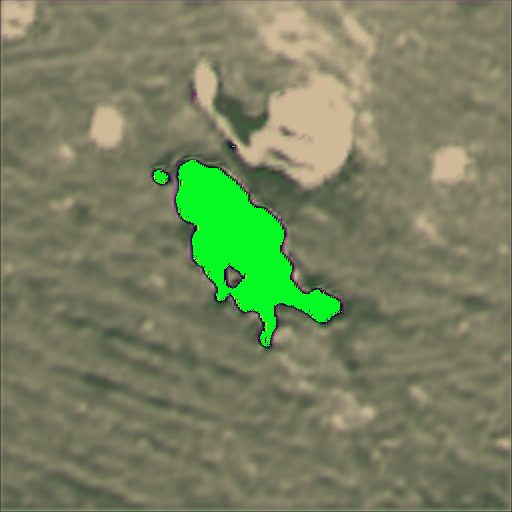

In [33]:
pil(pred)

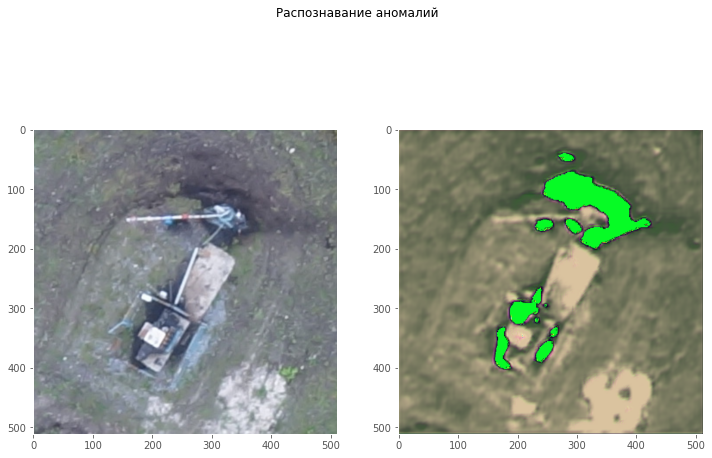

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))
fig.suptitle('Распознавание аномалий')
ax1.imshow(pil(x))
ax2.imshow(pil(model(x[None])[0]))
ax1.grid(False)
ax2.grid(False)

Предсказанные тензоры содержат числа, меньшие нуля (на местах аномалий), которые matplotlib заменяет на числа из промежутка [0, 255]. Попробуем выделить получившиеся области, выставив порог 0

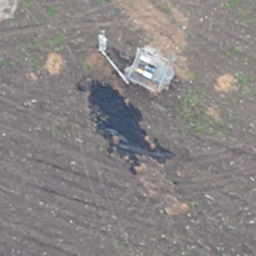

In [10]:
pil(x).resize((256,256))

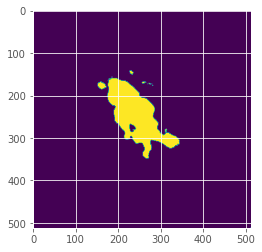

In [8]:
pil(pred<0)

Видим чётко выделенный сегмент с аномалией. Данный подход сегментирует разливы нефти с точностью IOU 70%

Таким образом, мы смогли сегментировать области интересующих нас аномалий. Хотелось бы теперь, чтобы на вход модели всегда приходили фотографии, содержащие скважины крупным планом. Тогда, если будут обнаружены большие отклонения метрик, то на картинке, вероятно, аномалия. То есть нам нужно как-то вырезать прямоугольные области из оригинальной фотографии, содержащие скважины. А дальше подавать её в автоэнкодер или использовать в дальнейшем для дообучения других моделей. Данную задачу отлично решают детекторы (Часть 3)